# Now creating a new script for first computing density from the dataset, then creating a grid with the same x-distance, then computing windstress and aligning with the ferrybox data by interpolating windstress data to the ferrybox.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
from pathlib import Path
import cmocean as cmo
import numpy as np
import gsw
from pathlib import Path

In [35]:
# Function to load ONE file
def load_files(filepath: str | Path) -> pd.DataFrame:
    """
    Read an SBE text export that has metadata lines before the real header.
    Returns a tidy DataFrame with an extra 'datetime' column.
    """
    filepath = Path(filepath)

    # detect how many metadata lines to skip ------------------
    with filepath.open('r', encoding='latin1') as f:
        for i, line in enumerate(f):
            if line.strip().startswith("Date") and "Time" in line:
                skiprows = i
                break

    # read the rest ------------------------------------------
    df = pd.read_csv(
        filepath,
        sep=r'\s+',                 # whitespace delimiter
        skiprows=skiprows,          # jump over metadata
        encoding='latin1'
    )

    # combine date/time to real datetime ----------------------
    df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
    df['source']   = filepath.stem   # keep the filename → handy for legends
    df = df.iloc[1:]                # drop the first data row
    return df


# 2.  Load desired files

files = [
    r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\224_2025-05-06_07.35.09__to_Skagen_741601.txt", #Dag 1 
    #r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\2025-05-07_07.11.44_Skagen_to__741601.txt", # Halva dag 2
    #r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\225_2025-05-07_07.11.44_Skagen_to_Skagen_741601.txt", # Hela dag 2
    r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\2025-05-08_07.24.29_Skagen_to__741601.txt" #Dag 3
]
dfs = [load_files(f) for f in files]

# Concatenate if you just want one big table:
df_all = pd.concat(dfs, ignore_index=True)

Remove/Interpolate the outlier in the transect from skagen to gbg, last day

In [36]:
# New way thats working
# There is one outlier in the temp data, I will flag it and then interpolate inbetween

# # flag outliers
# bad = df_all['Temp_in_SBE38'] > 100            # any value > 100 °C is impossible  
# df_all.loc[bad, 'Temp_in_SBE38'] = np.nan      # set those outliers to NaN

df_all['Temp_in_SBE38'] = df_all['Temp_in_SBE38'].mask(df_all['Temp_in_SBE38'] > 100)

# # interpolate the gaps
# df_all = df_all.set_index('datetime')              # make time the index  
# df_all['Temp_in_SBE38'] = df_all['Temp_in_SBE38'].interpolate('time')  # linear fill in time  
# df_all = df_all.reset_index()                      # restore datetime as a column

Get the sigma density and Cons. temp and abs. sal

In [37]:
# Convert everything to TEOS-10
SP  = df_all['Salinity_SBE45'].to_numpy()   # practical salinity is what we have in the dataset, will convert to Absolute sal
T   = df_all['Temp_in_SBE38'].to_numpy()    # in-situ temp (°C, ITS-90), will convert to Conservative T
p   = df_all['pressure'].to_numpy() / 100.0    # mbar → dbar  (1 dbar = 100 mbar)
lon = df_all['Longitude'].to_numpy()
lat = df_all['Latitude'].to_numpy()

SA = gsw.SA_from_SP(SP, p, lon, lat)    # absolute salinity
CT = gsw.CT_from_t(SA, T, p)            # conservative temp

# Store everything in the the dataset
df_all['SA'] = SA
df_all['CT'] = CT
df_all['press_db'] =p
df_all['sigma0'] = gsw.sigma0(SA, CT)       # potential density anomaly σθ

Compute Boyancy gradient

In [38]:
df_all['press_db']

0      2.063452
1      2.064273
2      2.063253
3      1.996940
4      2.034308
         ...   
814    1.983000
815    1.949644
816    1.946918
817    1.932401
818    1.928807
Name: press_db, Length: 819, dtype: float64

In [68]:
import numpy as np
from pyproj import Geod
from scipy.interpolate import interp1d
import gsw

# Constants
g = 9.81                 # gravity (m/s^2)
target_depth = 2.0       # target depth (meters)
depth_window = 0.5       # allowable depth variation (± meters)
dx = 100.0              # horizontal resolution (meters)
geod = Geod(ellps="WGS84")

# Step 1: Convert pressure to depth (m)
df_all['Depth'] = -gsw.z_from_p(df_all['pressure'] / 100, df_all['Latitude'])
depth = df_all["Depth"].to_numpy()

print(f"\n--- DEPTH ---")
print(f"Min depth: {np.nanmin(depth):.3f} m, Max depth: {np.nanmax(depth):.3f} m")

# Step 2: Filter to ~2 m depth
mask = np.abs(depth - target_depth) <= depth_window
print(f"\n--- FILTER ---")
print(f"Points near {target_depth} m (±{depth_window} m): {np.sum(mask)} / {len(depth)}")

if np.sum(mask) < 10:
    raise ValueError("Not enough points near the target depth for reliable gradient computation.")

# Subset the filtered data
df_near_depth = df_all[mask].copy()
lon = df_near_depth["Longitude"].to_numpy()
lat = df_near_depth["Latitude"].to_numpy()
sigma0 = df_near_depth["sigma0"].to_numpy()

# Step 3: Compute density and buoyancy
rho = sigma0 + 1000.0
rho0 = 1025
rho0 = np.nanmean(rho)
b = g * (1 - (rho / rho0))

print(f"\n--- DENSITY ---")
print(f"rho0 (mean): {rho0:.3f} kg/m³")
print(f"rho range: {np.nanmin(rho):.3f} – {np.nanmax(rho):.3f} kg/m³")
print(f"buoyancy (b) range: {np.nanmin(b):.2e} – {np.nanmax(b):.2e} m/s²")

# Step 4: Compute cumulative distance along track

# Calculate distances
_, _, step = geod.inv(lon[:-1], lat[:-1], lon[1:], lat[1:])
dist = np.concatenate(([0.0], np.cumsum(step)))

# Filter out steps < threshold (e.g., 50 m)
valid = np.concatenate(([True], step > 50))
lon = lon[valid]
lat = lat[valid]
b = b[valid]
dist = np.concatenate(([0.0], np.cumsum(geod.inv(lon[:-1], lat[:-1], lon[1:], lat[1:])[2])))


# Recalculate step after filtering
_, _, step_filtered = geod.inv(lon[:-1], lat[:-1], lon[1:], lat[1:])
print(f"\n--- DISTANCE ---")
print(f"Step sizes (m): min {np.min(step_filtered):.1f}, max {np.max(step_filtered):.1f}")

print(f"Total distance: {dist[-1]:.1f} m")

# Step 5: Interpolate buoyancy onto regular grid
d_reg = np.arange(0, dist[-1], dx)
b_reg = interp1d(dist, b, bounds_error=False, fill_value=np.nan)(d_reg)

print(f"\n--- INTERPOLATED BUOYANCY ---")
print(f"b_reg range: {np.nanmin(b_reg):.2e} – {np.nanmax(b_reg):.2e} m/s²")
print(f"Interpolated points: {len(b_reg)}")

# Step 6: Compute buoyancy gradient
dbdx_reg = np.gradient(b_reg, dx)

print(f"\n--- BUOYANCY GRADIENT (∂b/∂x) ---")
print(f"Gradient range: {np.nanmin(dbdx_reg):.2e} – {np.nanmax(dbdx_reg):.2e} s⁻²")

# Step 7: Map gradient back to original points (irregular spacing)
buoy_grad = np.interp(dist, d_reg, dbdx_reg, left=np.nan, right=np.nan)
# Create a filtered dataframe that matches filtered lon/lat/b
df_clean = df_near_depth.iloc[valid].copy()
df_clean["buoy_grad"] = buoy_grad


print(f"\n--- FINAL buoy_grad on original points ---")
print(f"Range: {np.nanmin(buoy_grad):.2e} – {np.nanmax(buoy_grad):.2e} s⁻²")
print(f"Non-NaN values: {np.sum(~np.isnan(buoy_grad))} / {len(buoy_grad)}")



--- DEPTH ---
Min depth: 1.802 m, Max depth: 2.209 m

--- FILTER ---
Points near 2.0 m (±0.5 m): 819 / 819

--- DENSITY ---
rho0 (mean): 1020.249 kg/m³
rho range: 1015.961 – 1023.330 kg/m³
buoyancy (b) range: -2.96e-02 – 4.12e-02 m/s²

--- DISTANCE ---
Step sizes (m): min 49.9, max 522.1
Total distance: 229578.6 m

--- INTERPOLATED BUOYANCY ---
b_reg range: -2.96e-02 – 4.03e-02 m/s²
Interpolated points: 2296

--- BUOYANCY GRADIENT (∂b/∂x) ---
Gradient range: -4.27e-05 – 3.64e-05 s⁻²

--- FINAL buoy_grad on original points ---
Range: -4.08e-05 – 2.62e-05 s⁻²
Non-NaN values: 686 / 690


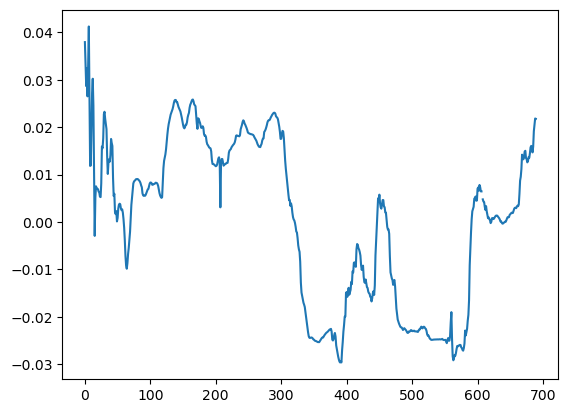

In [70]:
plt.plot(b)

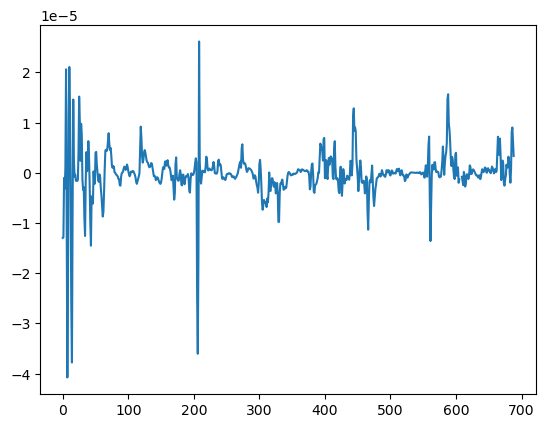

In [42]:
plt.plot(buoy_grad)

In [78]:
# saving the regular grid in the dataframe

df_dbdx = pd.DataFrame({
    "distance_m": d_reg,
    "buoyancy": b_reg,
    "dbdx": dbdx_reg})


In [79]:
print(df_dbdx.columns)

Index(['distance_m', 'buoyancy', 'dbdx'], dtype='object')


Open the weather data to compute the Ekman bouyancy flux (Dont mind the position data)

In [80]:
df_wind = pd.read_csv(r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\sk_weather.csv")
# df_pos = pd.read_csv(r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\sk_position.csv")

In [81]:
df_wind['ts'] = pd.to_datetime(df_wind['ts']).dt.round('1s')
# df_pos['ts'] = pd.to_datetime(df_pos['ts']).dt.round('1s')

# df = pd.merge(df_pos, df_wind, on='ts', how='inner')

In [82]:
df_wind = df_wind.rename(columns={'ts': 'Time'})
df_wind = df_wind.rename(columns={'longitude': 'Longitude'})
df_wind = df_wind.rename(columns={'latitude': 'Latitude'})

Compute windstress

In [83]:
# Get windstress

# ── 2.  vectorised air-density ρ_a(T, p, RH) ───────────────────────────
T   = df_wind['airtemp'].to_numpy(float)         # °C
P   = df_wind['airpressure'].to_numpy(float) * 100    # hPa → Pa
RH  = df_wind['humidity'].to_numpy(float) / 100     # %

Rd, Rv = 287.05, 461.5
es = 611.2 * np.exp((17.67 * T) / (T + 243.5))   # Pa (sat. vapour press.)
e  = RH * es                                     # Pa (actual vapour press.)
rho_air = (P - e) / (Rd * (T + 273.15)) + e / (Rv * (T + 273.15))

# ── 3.  wind-vector components (u, v) from speed + “from” direction ────
U     = df_wind['windspeed'].to_numpy(float)          # m s⁻¹
theta = np.deg2rad(df_wind['winddir'].to_numpy(float))

u = -U * np.sin(theta)      # eastward (+ = toward east)
v = -U * np.cos(theta)      # northward (+ = toward north)

# ── 4.  constant drag coefficient & wind-stress components ─────────────
Cd   = 1.5e-3                                    # dimensionless
tau  = rho_air * Cd * U**2                       # magnitude  (N m⁻²)
tau_x = rho_air * Cd * U * u                     # eastward stress
tau_y = rho_air * Cd * U * v                     # northward stress

# store in DataFrame
df_wind['tau']   = tau
df_wind['tau_x'] = tau_x
df_wind['tau_y'] = tau_y

# ── 5.  quick sanity print ─────────────────────────────────────────────
print(df_wind[['Time', 'tau', 'tau_x', 'tau_y']].head())

                 Time       tau     tau_x     tau_y
0 2025-05-06 07:00:00  0.021691 -0.004510 -0.021217
1 2025-05-06 07:01:00  0.020434 -0.004597 -0.019910
2 2025-05-06 07:02:00  0.018033  0.008466 -0.015922
3 2025-05-06 07:03:00  0.011727 -0.001429 -0.011640
4 2025-05-06 07:04:00  0.027085  0.001889 -0.027019


Sortera winddatan och ferrybox datan på tid för att kunna aligna dom

In [84]:
df_all['datetime'] = pd.to_datetime(df_all['Date'].astype(str) + ' ' + df_all['Time'].astype(str))
df_wind['datetime'] = pd.to_datetime(df_wind['Time'])

df_all = df_all.sort_values('datetime')
df_wind = df_wind.sort_values('datetime')  

In [85]:
# Add distance to df_clean (which corresponds to the buoyancy and positions)
df_clean['dist_m'] = dist


In [86]:
print(df_wind)

                    Time  airtemp  humidity  airpressure  windspeed  winddir  \
0    2025-05-06 07:00:00      8.8        42       1014.2        3.4       12   
1    2025-05-06 07:01:00      8.8        42       1014.2        3.3       13   
2    2025-05-06 07:02:00      8.8        43       1014.3        3.1      332   
3    2025-05-06 07:03:00      8.8        42       1014.2        2.5        7   
4    2025-05-06 07:04:00      8.9        42       1014.2        3.8      356   
...                  ...      ...       ...          ...        ...      ...   
3253 2025-05-08 13:13:00     11.0        59       1018.7        3.6      275   
3254 2025-05-08 13:14:00     11.1        60       1018.6        0.5      170   
3255 2025-05-08 13:15:00     11.1        57       1018.5        0.8      297   
3256 2025-05-08 13:16:00     11.0        56       1018.5        1.7      281   
3257 2025-05-08 13:17:00     11.0        56       1018.6        4.1      280   

           tau     tau_x     tau_y     

In [87]:
wind_interp_cols = ['tau_x', 'tau_y', 'tau']

# Interpolate wind variables to df_clean['datetime'] first
df_wind = df_wind.set_index('Time')

for var in wind_interp_cols:
    interp_func = interp1d(df_wind.index.astype(np.int64), df_wind[var], bounds_error=False, fill_value=np.nan)
    df_clean[var] = interp_func(df_clean['datetime'].astype(np.int64))

# Now interpolate to regular distance grid
for var in wind_interp_cols:
    interp_func = interp1d(df_clean["dist_m"], df_clean[var], bounds_error=False, fill_value=np.nan)
    df_dbdx[var] = interp_func(d_reg)




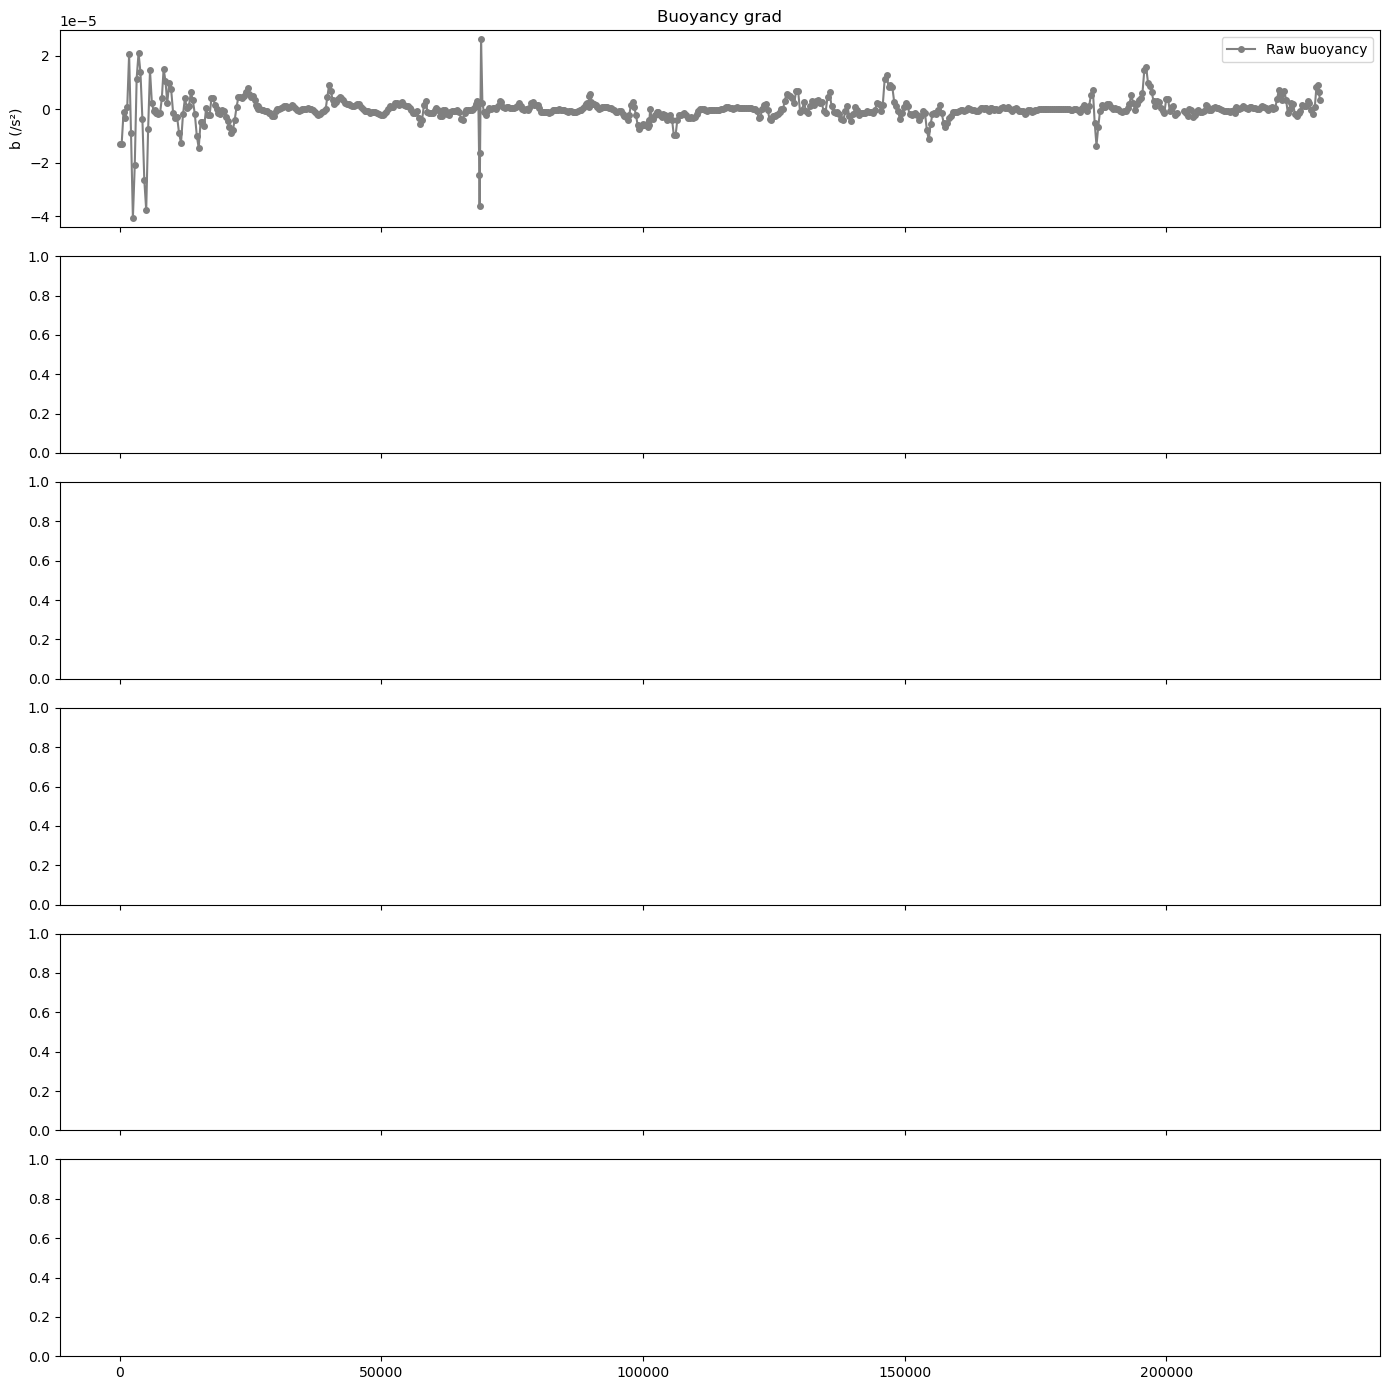

In [88]:
fig, axs = plt.subplots(6, 1, figsize=(14, 14), sharex=True)

# 1. Raw buoyancy
axs[0].plot(df_clean['dist_m'], df_clean['buoy_grad'], 'o-', color='gray', markersize=4, label='Raw buoyancy')
axs[0].set_ylabel("b (/s²)")
axs[0].set_title("Buoyancy grad")
axs[0].legend()

# 2. Temperature
# axs[1].plot(dist, df_clean["CT"].to_numpy(), 'o-', color='orange', markersize=4, label='Temperature')
# axs[1].set_ylabel("T (°C)")
# axs[1].set_title("Temperature Along Track")
# axs[1].legend()

# # 3. Salinity
# axs[2].plot(dist, df_clean["SA"].to_numpy(), 'o-', color='purple', markersize=4, label='Salinity')
# axs[2].set_ylabel("S (PSU)")
# axs[2].set_title("Salinity Along Track")
# axs[2].legend()


# # 4. Interpolated buoyancy
# axs[3].plot(d_reg, b_reg, 'o-', color='blue', markersize=4, label='Interpolated buoyancy')
# axs[3].set_ylabel("b (m/s²)")
# axs[3].set_title("Interpolated Buoyancy (Regular Grid)")
# axs[3].legend()

# # 5. Raw vs Interpolated gradient
# axs[4].plot(dist[:-1], np.diff(b) / step_filtered, 'o-', color='red', markersize=4, label='Raw ∂b/∂x (irregular)')
# axs[4].plot(d_reg, dbdx_reg, 'o-', color='blue', markersize=4, label='Interpolated ∂b/∂x (regular)')
# axs[4].set_ylabel("∂b/∂x (s⁻²)")
# axs[4].set_title("Comparison of Raw and Interpolated Horizontal Buoyancy Gradient")
# axs[4].legend()

# # 6. Smoothed gradient
# axs[5].plot(d_reg, dbdx_reg_smooth, 'o-', color='green', markersize=4, label='Smoothed ∂b/∂x (regular)')
# axs[5].set_ylabel("∂b/∂x (s⁻²)")
# axs[5].set_xlabel("Distance Along Track (m)")
# axs[5].set_title("Smoothed Gradient on Regular Grid")
# axs[5].legend()

plt.tight_layout()
plt.show()


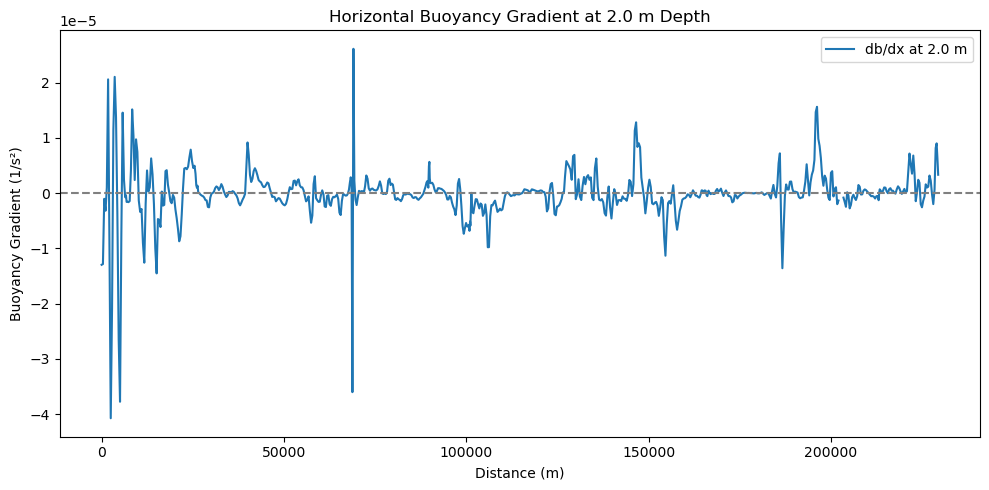

In [89]:
# Plot
plt.figure(figsize=(10, 5))
plt.plot(df_clean['dist_m'], df_clean['buoy_grad'], label=f'db/dx at {target_depth} m')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Distance (m)')
plt.ylabel('Buoyancy Gradient (1/s²)')
plt.title(f'Horizontal Buoyancy Gradient at {target_depth} m Depth')
plt.legend()
plt.tight_layout()
plt.show()


Compute corilois and then EBF

In [90]:
omega = 7.2921 * 10**-5  # Earth's rotation rate in rad/s
theta = 57  # Latitude in degrees

# Convert to radians
theta_rad = np.deg2rad(theta)

# Compute Coriolis parameter
f = 2 * omega * np.sin(theta_rad)

print(f"Coriolis parameter at {theta}°: {f:.3e} s⁻¹")


Coriolis parameter at 57°: 1.223e-04 s⁻¹


In [91]:
print(df_clean['CT'].max())

11.79386801816512


In [ ]:
# Step 1: Compute alpha in df_clean
df_clean['alpha'] = gsw.alpha(df_clean['SA'], df_clean['CT'], df_clean['pressure'] / 100)

# Step 2: Merge alpha into combo using datetime
#combo = pd.merge(df_clean[['datetime', 'alpha']], on='datetime', how='left')
combo = pd.merge(combo, df_clean[['datetime', 'alpha']], on='datetime', how='left')


# Step 3: Now compute Q_EBF
combo['Q_EBF'] = -((combo['buoy_grad'] * combo['tau']) / f) * (Cp / (combo['alpha'] * g))


In [96]:
# prepare the two source tables
bx   = df_clean[['datetime', 'buoy_grad', 'Longitude', 'Latitude']]      
tau  = df_clean[['datetime','tau']]  # 

# inner-join ⇒ keeps only timestamps present in **both** tables
combo = pd.merge(bx, tau, on='datetime', how='inner')


# Constants
Cp = 4000 # J kg-1 K-1 # specific heat of water
# alpha = 10**-4
#alpha = 5.7
alpha = gsw.alpha(SA, CT, p)
g = 9.82
#tau_const = 0.02

#combo['Q_EBF'] = -((combo['buoy_grad'] * combo['tau']) / (f)) * ((Cp) / (alpha * g))
combo['Q_EBF'] = -((combo['buoy_grad'] * combo['tau']) / f) * (Cp / (alpha * g))


ValueError: operands could not be broadcast together with shapes (690,) (819,) 

In [60]:
df_clean['alpha']

0      0.000136
1      0.000137
2      0.000138
3      0.000136
4      0.000140
         ...   
814    0.000158
815    0.000157
816    0.000157
817    0.000157
818    0.000157
Name: alpha, Length: 690, dtype: float64

In [61]:
# # Constants
# Cp = 4000 # J kg-1 K-1 # specific heat of water
# alpha = 10**-4
# g = 9.82
# bx_const = 0.000000002
# tau_const = 0.02

# Q_EBF_const = -((bx_const * combo['tau']) / f) * (Cp / (alpha * g))

In [62]:
# print(df_filtered['tau'].mean())
# print(df_filtered['tau'].max())
# print(df_filtered['tau'].min())
# print(df_filtered['tau'].describe())
# print(df_filtered['windspeed_wind'].describe())

In [63]:
print(df_wind.columns)

Index(['airtemp', 'humidity', 'airpressure', 'windspeed', 'winddir', 'tau',
       'tau_x', 'tau_y', 'datetime'],
      dtype='object')


In [64]:
# #Q_EBF = -((df_filtered["buoy_grad"] * df_filtered['tau']) / (f)) * ((Cp) / (alpha *g))
# Q_EBF = -((df_clean["buoy_grad"] * df_clean['tau']) / (f)) * ((Cp) / (alpha *g))

KeyError: 'Q_EBF'

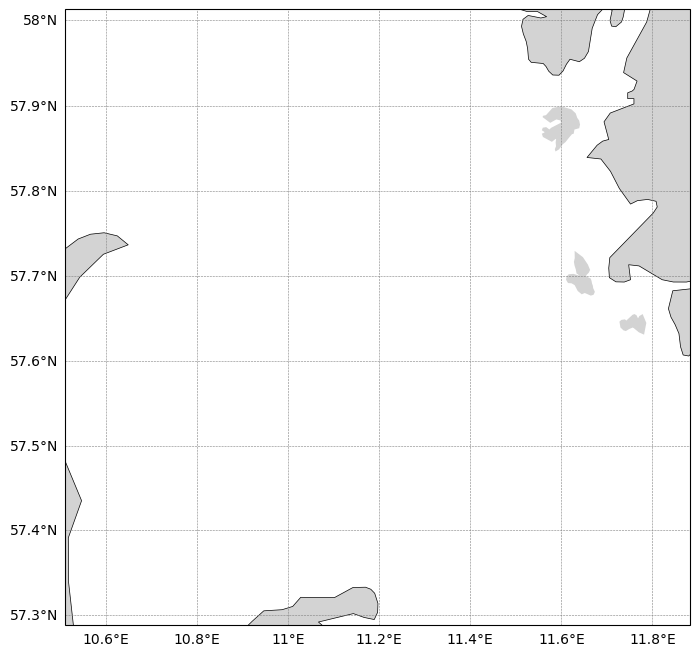

In [65]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Mercator())

# Define extent with buffer
lat_min, lat_max = combo['Latitude'].min(), combo['Latitude'].max()
lon_min, lon_max = combo['Longitude'].min(), combo['Longitude'].max()
extent = [lon_min - 0.1, lon_max + 0.1, lat_min - 0.1, lat_max + 0.1]

ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Gridlines with labels only on left and bottom
gl = ax.gridlines(draw_labels=True, linewidth=0.4, color="gray", linestyle="--")
gl.top_labels = False
gl.right_labels = False

# Scatter plot of Q_EBF
sc = ax.scatter(df_clean['Longitude'], df_clean['Latitude'],
                c=combo['Q_EBF'], cmap='coolwarm', s=30,
                transform=ccrs.PlateCarree())

# Colorbar
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Q$_{\\mathrm{EBF}}$ (W m$^{-2}$)')

ax.set_title('Q_EBF Filtered and with constants')
plt.tight_layout()
plt.show()


Plotta winddata för dag 8


In [69]:
print(df_wind.columns)

Index(['Time', 'airtemp', 'humidity', 'airpressure', 'windspeed', 'winddir',
       'tau', 'tau_x', 'tau_y'],
      dtype='object')


In [77]:
df_may_8 = df_wind[df_wind['Time'].astype(str).str.startswith('2025-05-08')]

In [80]:
print(df_may_8.columns)

Index(['Time', 'airtemp', 'humidity', 'airpressure', 'windspeed', 'winddir',
       'tau', 'tau_x', 'tau_y'],
      dtype='object')


In [81]:
import numpy as np

# Convert wind direction from degrees to radians
wind_dir_rad = np.radians(df['winddir'])

# Compute u (east-west) and v (north-south) components
# Since direction is "from", reverse it by adding 180 degrees
u = df['windspeed'] * np.sin(wind_dir_rad)
v = df['windspeed'] * np.cos(wind_dir_rad)


KeyError: 'lon'

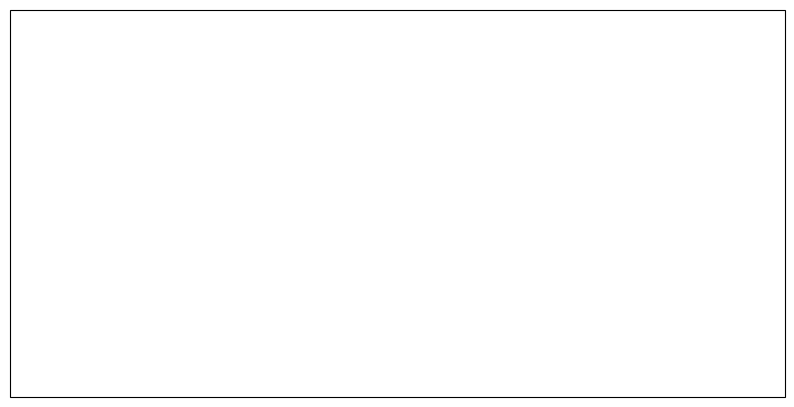

In [82]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Example: Assuming df has 'lat' and 'lon' columns
ax.quiver(df['lon'], df['lat'], u, v, transform=ccrs.PlateCarree())

# Add map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.gridlines(draw_labels=True)

plt.title("Wind Vectors")
plt.show()
